### Controlled: Grid Size

Fixed: Avarage variable value, Autocorrlation

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely import geometry as geom
import geopandas as gpd
import time

In [8]:
def create_queen_adjacency(n):
    """
    Create a queen adjacency matrix for an n x n grid.
    Each cell is connected to its 8 adjacent neighbors (N, S, E, W, NE, NW, SE, SW).
    
    Parameters:
    -----------
    n : int
        Size of the grid (n x n)
        
    Returns:
    --------
    W : scipy.sparse.csr_matrix
        Sparse adjacency matrix (n² x n²)
    """
    W = sp.lil_matrix((n * n, n * n))
    for row in range(n):
        for col in range(n):
            idx = row * n + col
            
            # Cardinal directions (same as rook)
            if row > 0:  # North
                W[idx, (row - 1) * n + col] = 1
            if row < n - 1:  # South
                W[idx, (row + 1) * n + col] = 1
            if col > 0:  # West
                W[idx, row * n + (col - 1)] = 1
            if col < n - 1:  # East
                W[idx, row * n + (col + 1)] = 1
                
            # Diagonal connections (unique to queen)
            if row > 0 and col > 0:  # Northwest
                W[idx, (row - 1) * n + (col - 1)] = 1
            if row > 0 and col < n - 1:  # Northeast
                W[idx, (row - 1) * n + (col + 1)] = 1
            if row < n - 1 and col > 0:  # Southwest
                W[idx, (row + 1) * n + (col - 1)] = 1
            if row < n - 1 and col < n - 1:  # Southeast
                W[idx, (row + 1) * n + (col + 1)] = 1
    
    # Return as CSR format for efficient operations
    return W.tocsr()

In [2]:
def row_standardize_sparse(W):
    """
    Row-standardize a sparse matrix efficiently.
    """
    W_csr = W.tocsr()
    row_sums = np.array(W_csr.sum(axis=1)).flatten()
    # Handle zero row sums to avoid division by zero
    row_sums[row_sums == 0] = 1
    
    # Create diagonal matrix with inverse of row sums
    D_inv = sp.diags(1.0 / row_sums)
    
    # Multiply to get row-standardized matrix
    W_std = D_inv @ W_csr
    return W_std

In [3]:
def simulate_sar_fixed_mean(W, rho, fixed_mean=0.15, sigma=1.0, random_seed=None):
    """
    Simulate a Spatial Autoregressive (SAR) process with a fixed mean.
    
    Model: y = (I - ρW)^(-1) * ε
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = W.shape[0]
    I = sp.identity(n, format='csr')
    
    # Generate random error terms
    epsilon = np.random.normal(0, sigma, size=n)
    
    # Calculate (I - ρW)^(-1)
    A_inv = inv((I - rho * W).toarray())
    
    # Compute SAR process: y = (I - ρW)^(-1) * ε
    y = A_inv @ epsilon
    
    # Adjust to the target mean while preserving variance structure
    y = y - np.mean(y) + fixed_mean
    
    return y

In [4]:
def create_df_for_simulation(simulation, n, grid_size, fixed_rho, fixed_mean):
    """
    Create a DataFrame for a simulation result.
    """
    df_index = pd.DataFrame({'Index': np.arange(n**2)})

    def calculate_square_coordinates(row, n):
        value = row['Index']
        x = value % n
        y = value // n
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    df_index['geometry'] = df_index.apply(lambda row: calculate_square_coordinates(row, n), axis=1)
    
    temp_df = df_index.copy()
    temp_df['Value'] = simulation
    temp_df['rho'] = fixed_rho
    temp_df['mean'] = fixed_mean
    temp_df['grid_size'] = n

    temp_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')
    return temp_gdf

In [5]:
def visualize_varying_grid_sizes(simulations, grid_sizes, fixed_rho, fixed_mean, cmap='coolwarm'):
    """
    Visualize spatial patterns with different grid sizes but fixed autocorrelation and mean.
    """
    # Number of columns in the grid
    ncols = min(4, len(grid_sizes))
    # Number of rows needed
    nrows = (len(grid_sizes) + ncols - 1) // ncols
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    if nrows == 1 and ncols == 1:
        axs = np.array([axs])
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    
    # Find global min and max for consistent color scaling
    vmin = min(sim_data.min() for n, sim_data in simulations.items())
    vmax = max(sim_data.max() for n, sim_data in simulations.items())
    
    for i, n in enumerate(grid_sizes):
        if i < len(axs):
            sim_data = simulations[n].reshape((n, n))
            im = axs[i].imshow(sim_data, cmap=cmap, vmin=vmin, vmax=vmax)
            axs[i].set_title(f"Grid Size = {n}x{n}\nMean = {simulations[n].mean():.3f}")
            axs[i].axis('off')
    
    # Hide any unused axes
    for i in range(len(grid_sizes), len(axs)):
        axs[i].axis('off')
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f"Spatial Patterns with Fixed Autocorrelation (ρ = {fixed_rho}) and Mean ({fixed_mean})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    return fig

Main Function

In [6]:
# Import the TDA utilities needed
from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

In [7]:
# Parameters
fixed_rho = 0.7  # Fixed autocorrelation level
fixed_mean = 0.8  # Fixed mean value
sigma = 1.0
random_seed = 42

# Vary the grid sizes (starting small and increasing)
grid_sizes = [4, 6, 8, 10, 12, 16, 20, 24]

# Initialize dictionary to store simulation results
simulations = {}
computation_times = {}

In [9]:
for n in grid_sizes:
    start_time = time.time()
    
    print(f"Processing grid size {n}x{n}...")
    
    # Create and standardize the adjacency matrix
    W = create_queen_adjacency(n)
    W_std = row_standardize_sparse(W)
    
    # Simulate with fixed autocorrelation and mean
    simulations[n] = simulate_sar_fixed_mean(W_std, fixed_rho, fixed_mean=fixed_mean, 
                                             sigma=sigma, random_seed=random_seed)
    
    end_time = time.time()
    computation_times[n] = end_time - start_time
    print(f"Grid size {n}x{n} completed in {computation_times[n]:.2f} seconds")

Processing grid size 4x4...
Grid size 4x4 completed in 0.02 seconds
Processing grid size 6x6...
Grid size 6x6 completed in 0.00 seconds
Processing grid size 8x8...
Grid size 8x8 completed in 0.00 seconds
Processing grid size 10x10...
Grid size 10x10 completed in 0.06 seconds
Processing grid size 12x12...
Grid size 12x12 completed in 0.28 seconds
Processing grid size 16x16...
Grid size 16x16 completed in 0.32 seconds
Processing grid size 20x20...
Grid size 20x20 completed in 0.26 seconds
Processing grid size 24x24...
Grid size 24x24 completed in 0.31 seconds


In [10]:
# Create GeoDataFrames for each simulation
geo_dataframes = {}
for n in grid_sizes:
    geo_dataframes[n] = create_df_for_simulation(simulations[n], n, grid_sizes, fixed_rho, fixed_mean)

# Calculate TDA summaries for each grid size
results_df = pd.DataFrame(columns=['Grid_Size', 'Num_Cells', 'Filter_Method', 'TL', 'AL', 'TML', 'AML', 'Actual_Mean', 'Computation_Time'])

In [11]:
for n in grid_sizes:
    print(f"Calculating TDA summaries for grid size {n}x{n}...")
    start_time = time.time()
    
    gdf = geo_dataframes[n]
    actual_mean = gdf['Value'].mean()
    
    # Calculate TDA summaries with downward filtration
    adj_simplex = AdjacencySimplex(gdf, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, _ = compute_persistence(simplices=simplex, filtered_df=filtered_df, variable_name='Value')
    
    end_time = time.time()
    tda_time = end_time - start_time
    
    # Add results to DataFrame
    new_row = pd.DataFrame({
        'Grid_Size': [f"{n}x{n}"],
        'Num_Cells': [n*n],
        'Filter_Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Actual_Mean': [actual_mean],
        'Computation_Time': [tda_time]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    print(f"TDA calculation completed in {tda_time:.2f} seconds")

Calculating TDA summaries for grid size 4x4...
TDA calculation completed in 0.04 seconds
Calculating TDA summaries for grid size 6x6...
TDA calculation completed in 0.02 seconds
Calculating TDA summaries for grid size 8x8...
TDA calculation completed in 0.03 seconds
Calculating TDA summaries for grid size 10x10...
TDA calculation completed in 0.04 seconds
Calculating TDA summaries for grid size 12x12...
TDA calculation completed in 0.06 seconds
Calculating TDA summaries for grid size 16x16...
TDA calculation completed in 0.13 seconds
Calculating TDA summaries for grid size 20x20...
TDA calculation completed in 0.19 seconds
Calculating TDA summaries for grid size 24x24...
TDA calculation completed in 0.32 seconds


In [12]:
# Convert numerical columns to float
numeric_cols = ['Num_Cells', 'TL', 'AL', 'TML', 'AML', 'Actual_Mean', 'Computation_Time']
results_df[numeric_cols] = results_df[numeric_cols].astype(float)


In [13]:
results_df

,Grid_Size,Num_Cells,Filter_Method,TL,AL,TML,AML,Actual_Mean,Computation_Time
0,4x4,16.0,down,49.433109,3.089569,24.716554,1.544785,0.8,0.042112
1,6x6,36.0,down,83.229774,2.311938,41.614887,1.155969,0.8,0.018301
2,8x8,64.0,down,142.288101,2.223252,71.144050,1.111626,0.8,0.028160
3,10x10,100.0,down,255.347726,2.553477,127.673863,1.276739,0.8,0.041331
4,12x12,144.0,down,435.774247,3.026210,217.887123,1.513105,0.8,0.059742
5,16x16,256.0,down,1258.601740,4.916413,629.300870,2.458207,0.8,0.133247
6,20x20,400.0,down,1620.937542,4.052344,810.468771,2.026172,0.8,0.194944
7,24x24,576.0,down,2976.882184,5.168198,1488.441092,2.584099,0.8,0.318521


Generating visualization of spatial patterns...


/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_43809/292553812.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


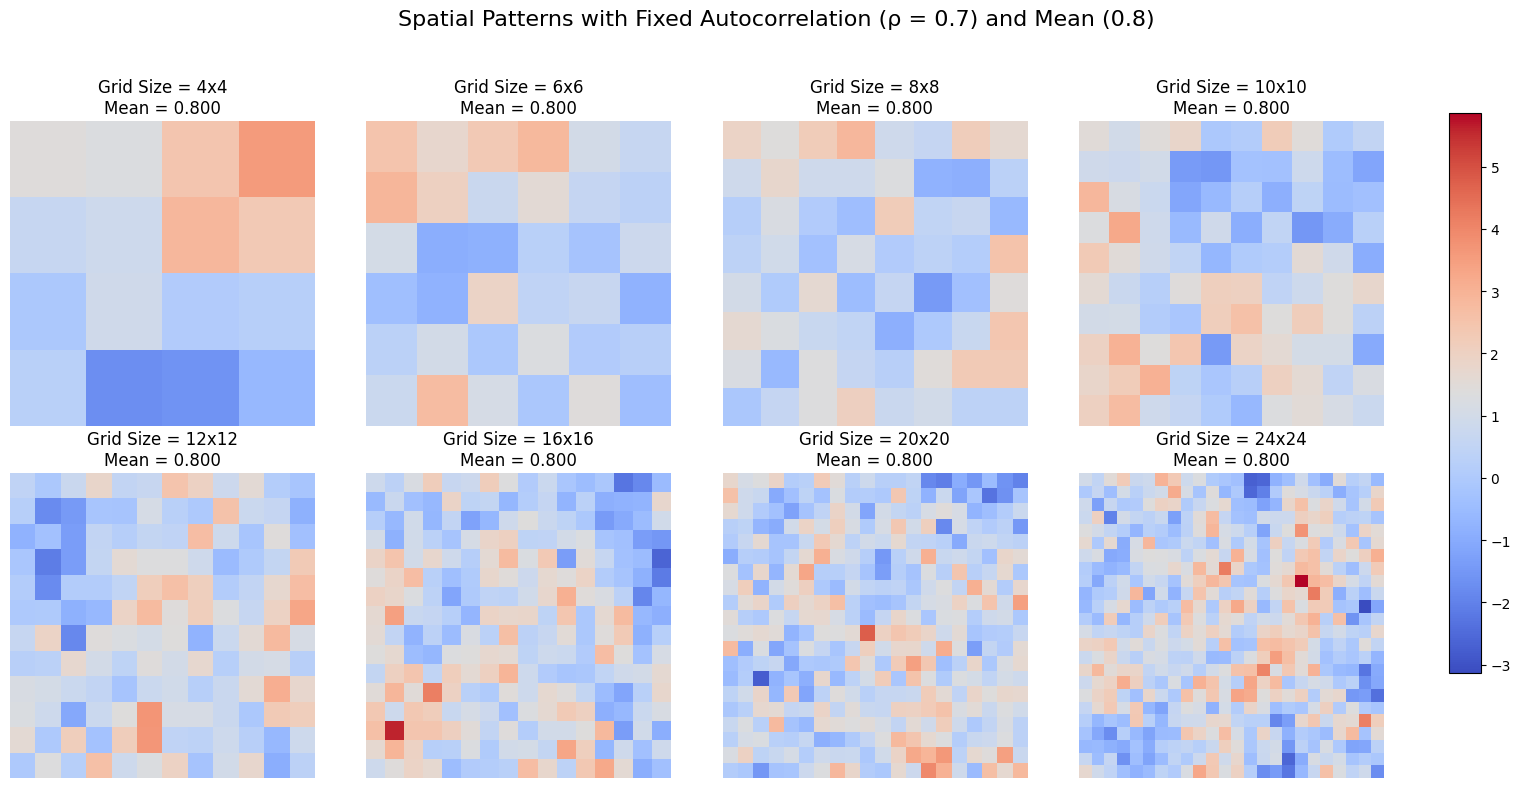

In [14]:
# Visualize the spatial patterns
print("Generating visualization of spatial patterns...")
fig_patterns = visualize_varying_grid_sizes(simulations, grid_sizes, fixed_rho, fixed_mean)
# plt.savefig('spatial_patterns_varying_grid_sizes.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

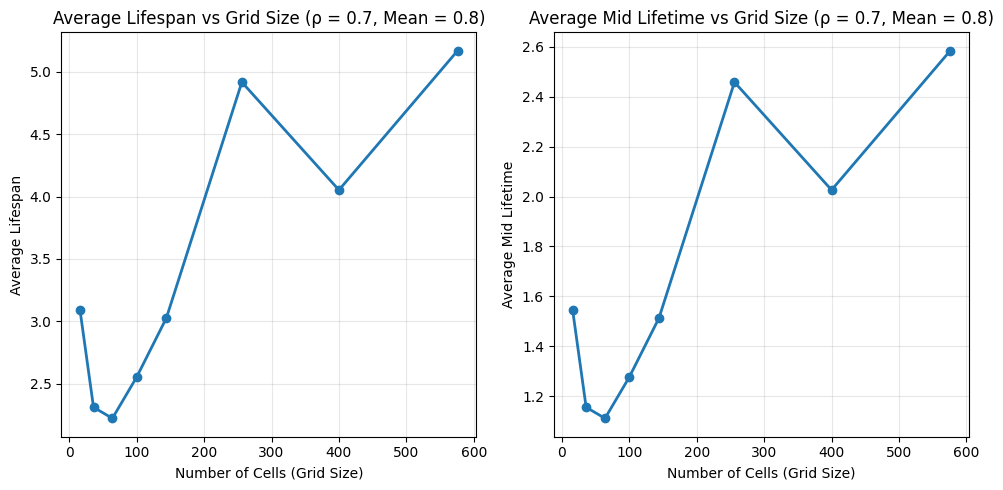

In [17]:
# Plot TDA summaries vs grid sizes
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

measures = ['AL', 'AML']
titles = ['Average Lifespan', 'Average Mid Lifetime']

for i, (measure, title) in enumerate(zip(measures, titles)):
    axes[i].plot(results_df['Num_Cells'], results_df[measure], marker='o', linestyle='-', linewidth=2)
    axes[i].set_xlabel('Number of Cells (Grid Size)')
    axes[i].set_ylabel(title)
    axes[i].set_title(f'{title} vs Grid Size (ρ = {fixed_rho}, Mean = {fixed_mean})')
    axes[i].grid(True, alpha=0.3)
    # Set x-axis to log scale for better visualization of the range
    # axes[i].set_xscale('log')

plt.tight_layout()
# plt.savefig('tda_measures_vs_grid_size.png', dpi=300)
plt.show()
plt.close()